In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sim_data import SimData

In [3]:
from simple_hierarchical_topic_model import SimpleHierarchicalTopicModel

In [4]:
from param_stats import mean_discrete, mean_dirichlet, variance_discrete, norm_variance_dirichlet

In [5]:
np.random.seed(1)

In [6]:
def custom_initializer(sim, topics_noise = 0.0):
    """
    A custom initializer that can be used to "cheat" and nudge the results closer
    to the desired values, based on stats from the simulation.
    We can use this to verify that variational inference can find the desired value
    if it starts sufficiently close to it.
    """
    result = dict()
    result["L"] = np.ones((sim.num_docs * sim.doc_length, sim.num_leaves))
    result["D"] = np.ones((sim.num_docs * sim.doc_length, sim.num_depths))
    result["DL"] = np.broadcast_to(sim.alpha_leaves, (sim.num_docs, sim.num_leaves))
    result["DD"] = np.broadcast_to(sim.alpha_depths, (sim.num_docs, sim.num_depths))
    init_DV = sim.topics_by_index + np.random.uniform(0.0, topics_noise, sim.topics_by_index.shape)
    result["DV"] = init_DV / np.min(init_DV)
    return result

In [7]:
%%time
sim = SimData(
    num_leaves = 2,
    num_docs = 100,
    doc_length = 100,
    topic_sharpness = 20,
    alpha_leaves = 0.01,
    alpha_depths = 0.01,
)
docs = sim.generate()

CPU times: user 232 ms, sys: 2.75 ms, total: 235 ms
Wall time: 237 ms


In [8]:
import os
import sys
sys.path.append(os.path.abspath(".."))
import text_utils

In [9]:
%%time
data, vocab = text_utils.document_strings_to_sparse_term_doc(
    docs = docs,
    tokenizer = text_utils.default_tokenizer,
    vocab = sim.vocab)

CPU times: user 241 ms, sys: 4.09 ms, total: 245 ms
Wall time: 245 ms


In [10]:
vocab

['w0', 'w1', 'w2', 'w3', 'w4', 'w5', 'w6', 'w7', 'w8', 'w9']

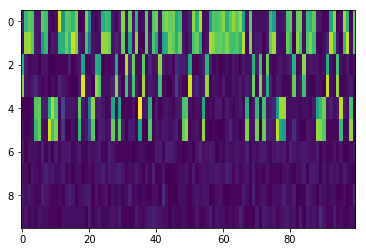

In [11]:
plt.imshow(data.todense(), aspect='auto');

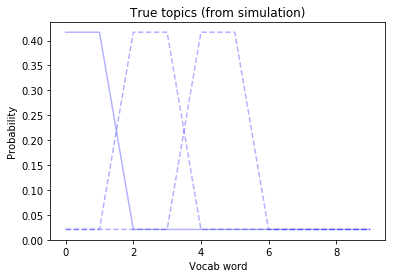

In [12]:
fig, ax = plt.subplots()
for i in range(len(sim.nodes)):
    linestyle = '-' if i == 0 else '--'
    ax.plot(sim.topics_by_index[i,:], color='b', linestyle=linestyle, alpha=0.3)
ax.set_title("True topics (from simulation)")
ax.set_xlabel("Vocab word")
ax.set_ylabel("Probability")
ax.set_ylim(0, None)
None

In [13]:
model = SimpleHierarchicalTopicModel(
    branching_factors = [sim.num_leaves],
    num_epochs = 100,
    batch_size = None,
    vocab = vocab,
    save_params_history = True,
    #update_order = ["D", "L", "DD", "DL", "DV", ],
    #custom_initializer = custom_initializer(sim, topics_noise = 0.1),
    # ^ "cheating" with custom initializer based on simulation
)

In [14]:
model.fit(data)
top_words = model.get_top_words_by_node(num_words = 10)
model.print_top_words_by_node(num_words = 10);

100%|██████████| 10000/10000 [00:04<00:00, 2255.43it/s, Status=computing statistics]

Top words by node:
()  : w1, w0, w9, w8, w6, w7, w4, w5, w2, w3
(0,): w5, w4, w6, w7, w9, w8, w2, w3, w1, w0
(1,): w3, w2, w7, w6, w8, w9, w0, w1, w4, w5


In [15]:
topic_vectors = model.get_expected_topic_vectors()

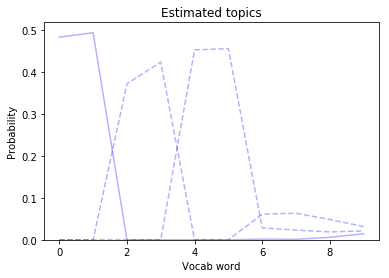

In [16]:
fig, ax = plt.subplots()
for i in range(len(sim.nodes)):
    linestyle = '-' if i == 0 else '--'
    ax.plot(topic_vectors[i,:], color='b', linestyle=linestyle, alpha=0.3)
ax.set_title("Estimated topics")
ax.set_xlabel("Vocab word")
ax.set_ylabel("Probability")
ax.set_ylim(0, None)
None

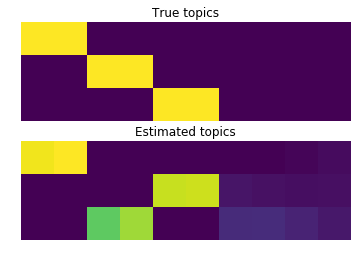

In [17]:
fig, ax = plt.subplots(2, 1)
ax[0].imshow(sim.topics_by_index);
ax[0].set_title("True topics");
ax[0].axis('off');
ax[1].imshow(topic_vectors);
ax[1].set_title("Estimated topics");
ax[1].axis('off');

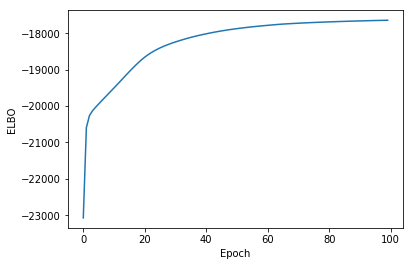

In [18]:
fig, ax = plt.subplots()
ax.plot(model.get_stats_by_epoch("epoch_index"), model.get_stats_by_epoch("ELBO"))
ax.set_xlabel("Epoch")
ax.set_ylabel("ELBO")
None

In [19]:
var_params = dict()
for name in ["DL", "DD", "DV", "L", "D"]:
    var_params[name] = model.get_stats_by_epoch("var_params_" + name)
epoch_indices = model.get_stats_by_epoch("epoch_index")

In [20]:
for k, v in var_params.items():
    print("{:2}: {}".format(k, v.shape))

DD: (101, 100, 2)
DL: (101, 100, 2)
DV: (101, 3, 10)
D : (101, 10000, 2)
L : (101, 10000, 2)


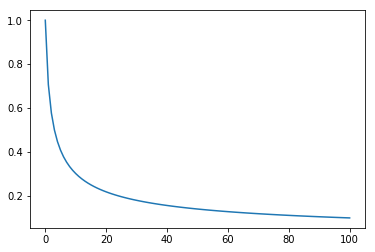

In [21]:
plt.plot(model.get_stats_by_epoch("step_size"));

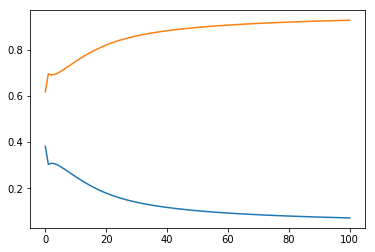

In [22]:
plt.plot(mean_dirichlet(var_params["DL"][:, 0, :]));

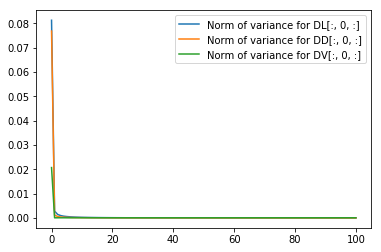

In [23]:
fig, ax = plt.subplots()
for name in ["DL", "DD", "DV"]:
    ax.plot(norm_variance_dirichlet(var_params[name][:, 0, :]),
        label = "Norm of variance for {}[:, 0, :]".format(name))
ax.legend(loc='best')
None

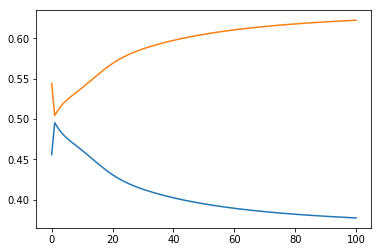

In [24]:
plt.plot(mean_dirichlet(var_params["DD"][:, 0, :]));

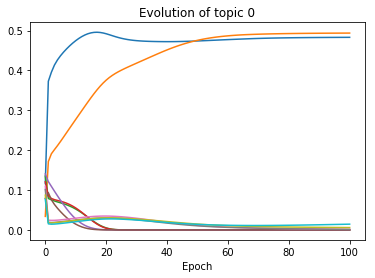

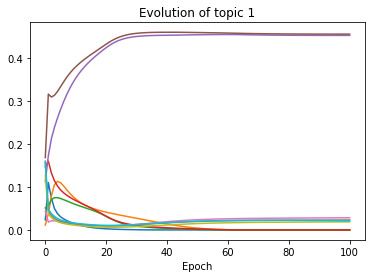

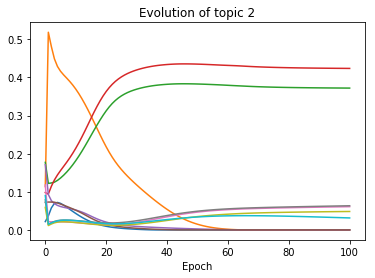

In [25]:
for i in range(sim.num_leaves + 1):
    fig, ax = plt.subplots()
    ax.plot(mean_dirichlet(var_params["DV"][:, i, :]))
    ax.set_title("Evolution of topic {}".format(i))
    ax.set_xlabel("Epoch")
None

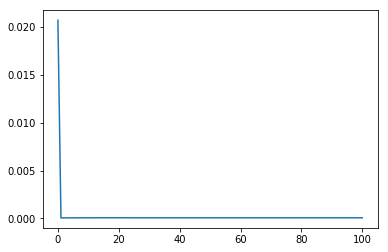

In [26]:
zzz = norm_variance_dirichlet(var_params["DV"][:, 0, :])
plt.plot(zzz);

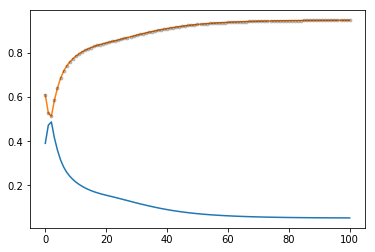

In [27]:
plt.plot(var_params["L"][:, 0, :]);
plt.plot(mean_discrete(var_params["L"][:, 0, :]), 'k.', alpha=0.2);

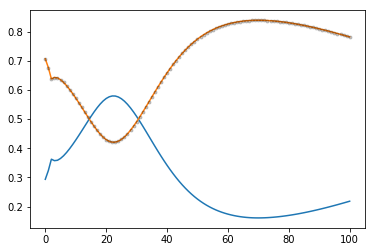

In [28]:
plt.plot(var_params["D"][:, 0, :]);
plt.plot(mean_discrete(var_params["D"][:, 0, :]), 'k.', alpha=0.2);

In [29]:
# Compare topic vectors to mean_dirichlet of most recent DV params (values should match)
zzz = mean_dirichlet(model.get_stats_by_epoch("var_params_DV")[-1, :, :])
np.linalg.norm(topic_vectors - zzz)

0.0

In [30]:
from scipy.stats import beta

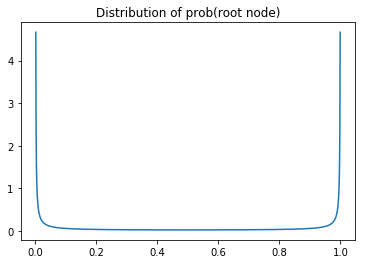

In [31]:
fig, ax = plt.subplots()
xx = np.linspace(0,1,1000)
yy = beta.pdf(xx, a=sim.alpha_depths[1], b=sim.alpha_depths[0])
ax.plot(xx, yy)
ax.set_title("Distribution of prob(root node)");

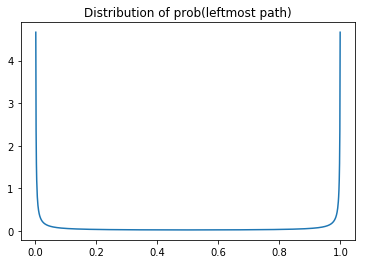

In [32]:
fig, ax = plt.subplots()
xx = np.linspace(0,1,1000)
yy = beta.pdf(xx, a=sim.alpha_leaves[1], b=sim.alpha_leaves[0])
ax.plot(xx, yy)
ax.set_title("Distribution of prob(leftmost path)");